In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
print(df.shape)
print(df.isnull().sum())
print(df.duplicated().sum())

(1599999, 6)
0                                                                                                                      0
1467810369                                                                                                             0
Mon Apr 06 22:19:45 PDT 2009                                                                                           0
NO_QUERY                                                                                                               0
_TheSpecialOne_                                                                                                        0
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D    0
dtype: int64
0


In [4]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df = df[['text', 'target']]
df['label'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

In [5]:
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

2025-07-01 18:22:10.476661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751394130.784561      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751394130.857304      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)
df["text_len"] = df["clean_text"].apply(len)
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


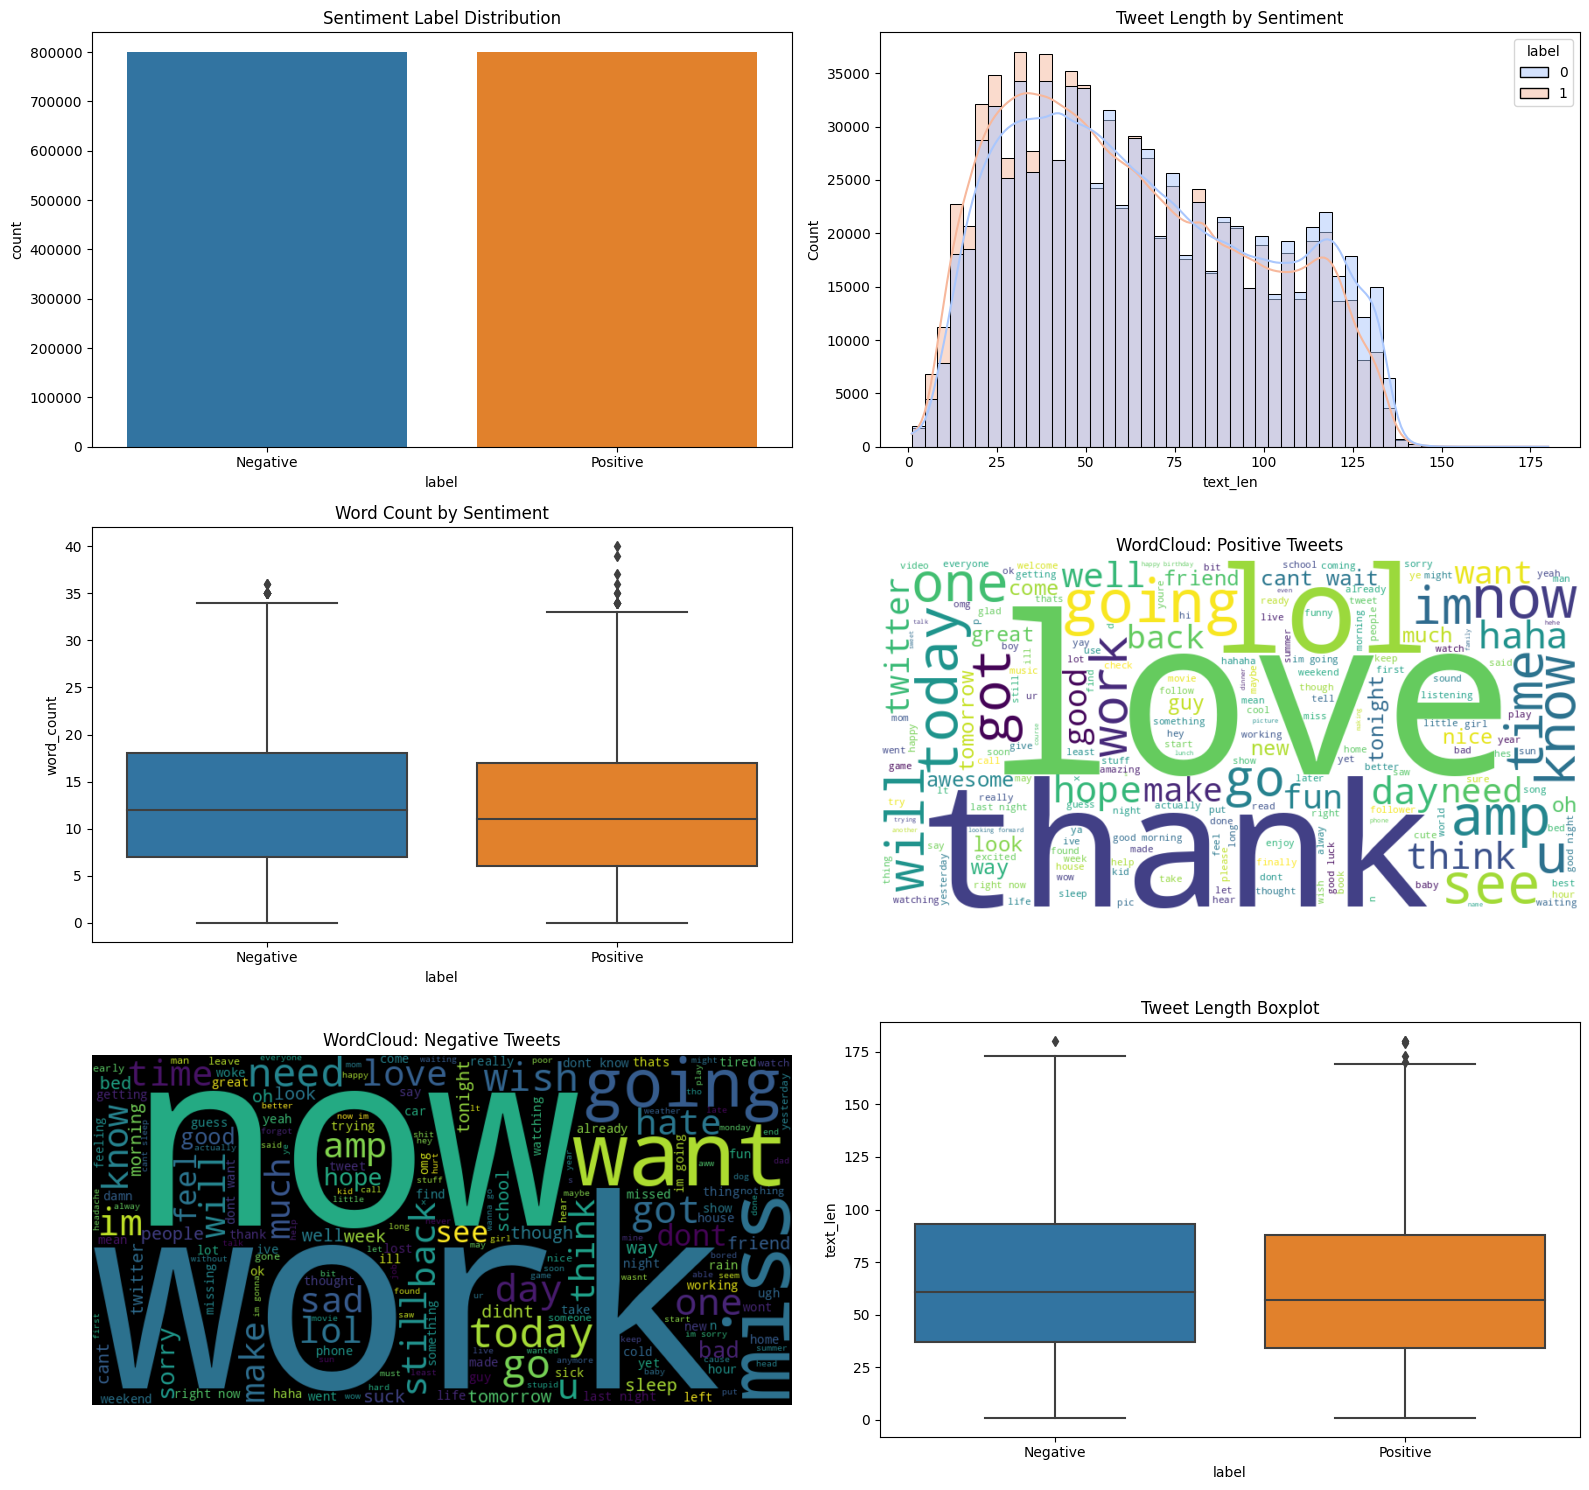

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

sns.countplot(data=df, x="label", ax=axes[0, 0])
axes[0, 0].set_title("Sentiment Label Distribution")
axes[0, 0].set_xticklabels(["Negative", "Positive"])

sns.histplot(data=df, x="text_len", hue="label", bins=50, ax=axes[0, 1], kde=True, palette="coolwarm")
axes[0, 1].set_title("Tweet Length by Sentiment")

sns.boxplot(data=df, x="label", y="word_count", ax=axes[1, 0])
axes[1, 0].set_title("Word Count by Sentiment")
axes[1, 0].set_xticklabels(["Negative", "Positive"])

wordcloud_pos = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(" ".join(df[df["label"] == 1]["clean_text"]))
axes[1, 1].imshow(wordcloud_pos, interpolation="bilinear")
axes[1, 1].axis("off")
axes[1, 1].set_title("WordCloud: Positive Tweets")

wordcloud_neg = WordCloud(width=800, height=400, background_color="black", stopwords=STOPWORDS).generate(" ".join(df[df["label"] == 0]["clean_text"]))
axes[2, 0].imshow(wordcloud_neg, interpolation="bilinear")
axes[2, 0].axis("off")
axes[2, 0].set_title("WordCloud: Negative Tweets")

sns.boxplot(data=df, x="label", y="text_len", ax=axes[2, 1])
axes[2, 1].set_title("Tweet Length Boxplot")
axes[2, 1].set_xticklabels(["Negative", "Positive"])

plt.tight_layout()
plt.show()

In [8]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from collections import Counter

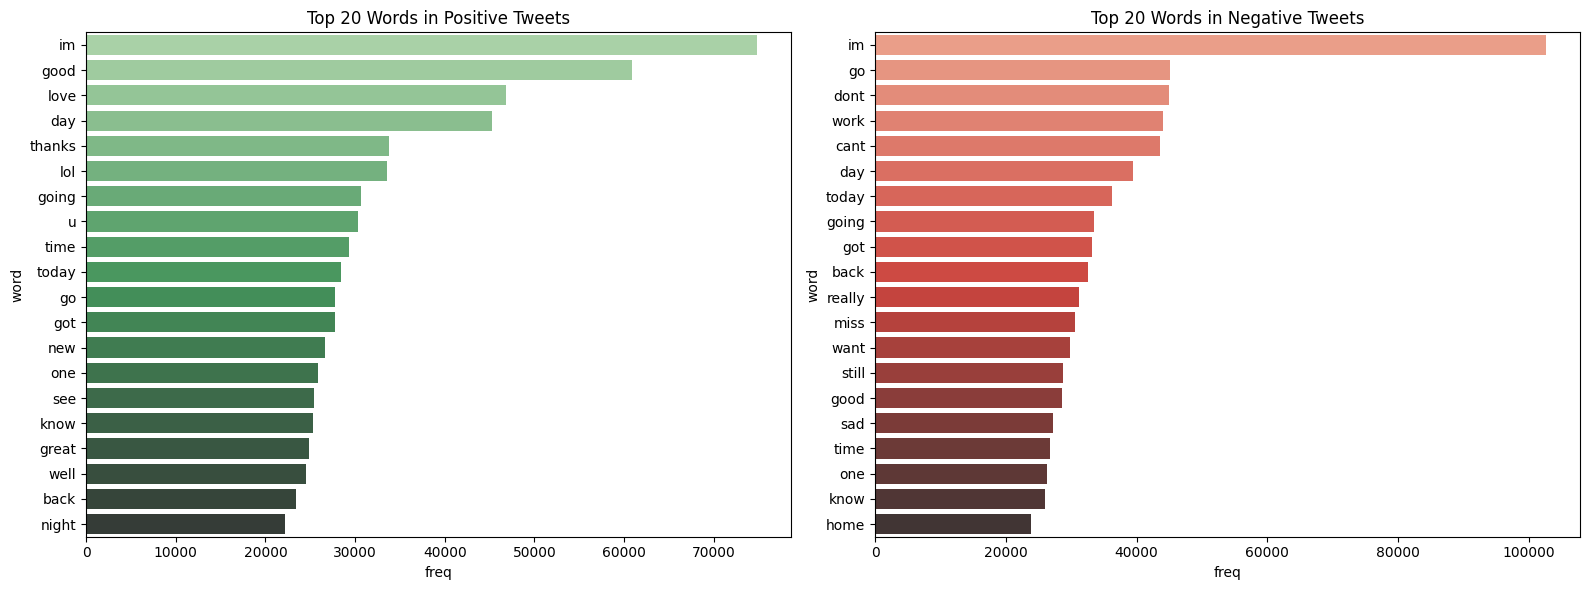

In [10]:
def get_top_n_words(corpus, n=None):
    words = " ".join(corpus).split()
    filtered = [word for word in words if word not in stop_words and word not in STOPWORDS]
    counter = Counter(filtered)
    return counter.most_common(n)

top_words_pos = get_top_n_words(df[df["label"] == 1]["clean_text"], 20)
top_words_neg = get_top_n_words(df[df["label"] == 0]["clean_text"], 20)

# Plot
df_top_pos = pd.DataFrame(top_words_pos, columns=["word", "freq"])
df_top_neg = pd.DataFrame(top_words_neg, columns=["word", "freq"])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df_top_pos, x="freq", y="word", ax=axes[0], palette="Greens_d")
axes[0].set_title("Top 20 Words in Positive Tweets")

sns.barplot(data=df_top_neg, x="freq", y="word", ax=axes[1], palette="Reds_d")
axes[1].set_title("Top 20 Words in Negative Tweets")

plt.tight_layout()
plt.show()


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


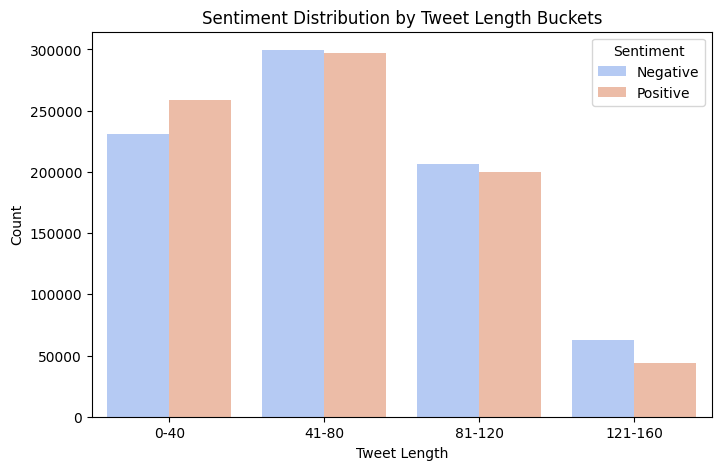

In [11]:
df['len_bucket'] = pd.cut(df['clean_text'].apply(len), bins=[0, 40, 80, 120, 160], labels=["0-40", "41-80", "81-120", "121-160"])

# Plot sentiment counts across buckets
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='len_bucket', hue='label', palette="coolwarm")
plt.title("Sentiment Distribution by Tweet Length Buckets")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()


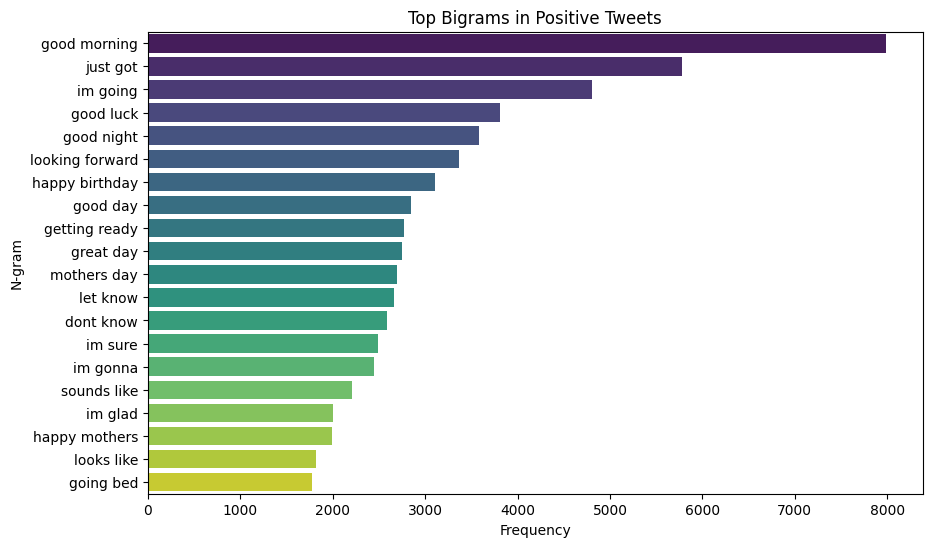

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(texts, ngram_range=(2,2), top_n=20, title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngrams = vec.fit_transform(texts)
    sum_words = ngrams.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_n]
    ngram_df = pd.DataFrame(word_freq, columns=["N-gram", "Frequency"])

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Frequency", y="N-gram", data=ngram_df, palette="viridis")
    plt.title(title)
    plt.show()

# Example: Top bigrams in positive tweets
plot_top_ngrams(df[df['label'] == 1]["clean_text"], ngram_range=(2,2), title="Top Bigrams in Positive Tweets")


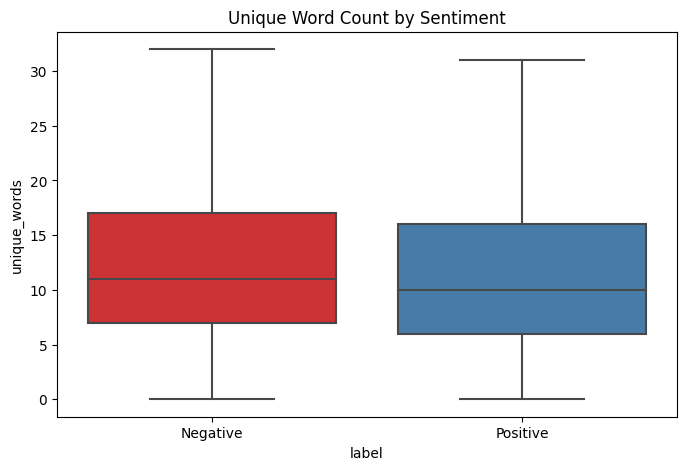

In [13]:
df["unique_words"] = df["clean_text"].apply(lambda x: len(set(x.split())))

plt.figure(figsize=(8, 5))
sns.boxplot(x="label", y="unique_words", data=df, palette="Set1")
plt.title("Unique Word Count by Sentiment")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()


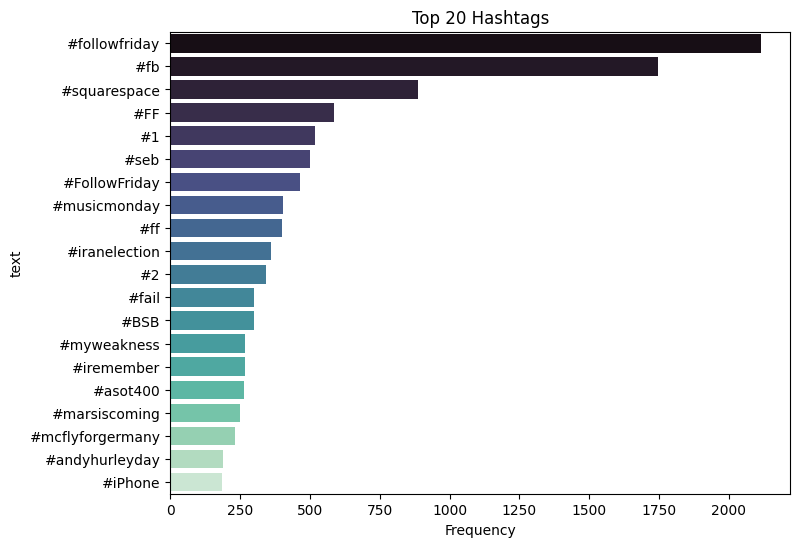

In [14]:
# If you didn’t clean hashtags, try this on original text
hashtags = df['text'].str.findall(r"#\w+").explode().dropna()
top_hashtags = hashtags.value_counts().head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_hashtags.values, y=top_hashtags.index, palette="mako")
plt.title("Top 20 Hashtags")
plt.xlabel("Frequency")
plt.show()


In [15]:
# ✅ Sample 6,000 rows
df_sampled = df.sample(n=6000, random_state=42).reset_index(drop=True)

# ✅ Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df_sampled['clean_text'], df_sampled['label'], test_size=0.2, stratify=df_sampled['label'], random_state=42
)

In [16]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from tqdm import tqdm
epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    model.train()
    correct = 0
    total = 0
    total_loss = 0

    loop = tqdm(train_loader, total=len(train_loader), leave=False)

    for step, batch in enumerate(loop, 1):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)
        total_loss += loss.item()
        acc = 100 * correct / total

        loop.set_description(f"{step}/{len(train_loader)} ---- {acc:.2f}%")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Complete — Avg Loss: {total_loss/len(train_loader):.4f} — Accuracy: {acc:.2f}%")



Epoch 1/3


Epoch 1 Complete — Avg Loss: 0.5065 — Accuracy: 74.81%

Epoch 2/3


Epoch 2 Complete — Avg Loss: 0.3143 — Accuracy: 87.46%

Epoch 3/3


Epoch 3 Complete — Avg Loss: 0.1503 — Accuracy: 94.96%


In [21]:
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        y_preds.extend(preds.cpu().numpy())
        y_true.extend(batch['labels'].cpu().numpy())

# ✅ Accuracy and Report
print("Test Accuracy:", accuracy_score(y_true, y_preds))
print("\nClassification Report:\n", classification_report(y_true, y_preds))

Test Accuracy: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.78       603
           1       0.76      0.85      0.80       597

    accuracy                           0.79      1200
   macro avg       0.79      0.79      0.79      1200
weighted avg       0.79      0.79      0.79      1200



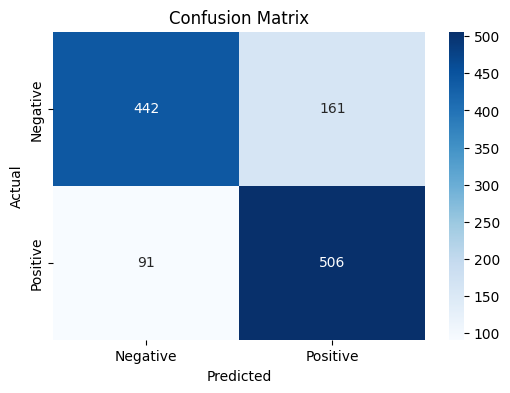

In [22]:
cm = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()